# **Twitch Sentiment Classification with BERT and Word2Vec**
**Authors: Ryan Jun Wang, Feifei Li, Victor Trinh**


[*Notebook based on CSC413's 2022 iteration assignment 3*](https://colab.research.google.com/github/uoft-csc413/2022/blob/master/assets/assignments/bert.ipynb)

## Pre-reqs

In [1]:
!nvidia-smi

Sat Apr 16 20:59:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    34W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install --upgrade transformers emoji datasets gensim
# https://huggingface.co/docs/transformers/training and BERT PA3 
#!pip install cloud-tpu-client==0.10 torch==1.11.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.11-cp37-cp37m-linux_x86_64.whl

     |████████████████████████████████| 4.0 MB 8.9 MB/s 
     |████████████████████████████████| 175 kB 13.9 MB/s 
     |████████████████████████████████| 325 kB 30.8 MB/s 
     |████████████████████████████████| 24.1 MB 59.1 MB/s 
     |████████████████████████████████| 596 kB 49.5 MB/s 
     |████████████████████████████████| 77 kB 6.6 MB/s 
     |████████████████████████████████| 895 kB 54.3 MB/s 
     |████████████████████████████████| 6.6 MB 23.9 MB/s 
     |████████████████████████████████| 136 kB 52.5 MB/s 
     |████████████████████████████████| 1.1 MB 45.2 MB/s 
     |████████████████████████████████| 212 kB 21.1 MB/s 
     |████████████████████████████████| 127 kB 57.5 MB/s 
     |████████████████████████████████| 271 kB 55.2 MB/s 
     |████████████████████████████████| 94 kB 131 kB/s 
     |████████████████████████████████| 144 kB 40.7 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=f25827cb90e7e19b1c3995a70c68f85376774eb46fd63e07cc

In [3]:
import os
import random

import numpy as np
import torch
import pandas as pd

# imports the torch_xla package
# import torch_xla
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

SEED = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

cuda


## Data Setup

### Data Loading

In [4]:
df = pd.read_csv("./data/labeled_dataset.csv")
print(f"{df.shape[0]} labelled samples")
df['sentiment_relevel'] = df['sentiment'].astype('category')
df['sentiment_relevel'] = df['sentiment_relevel'].cat.rename_categories({-1:0, 0:1, 1:2})
df.sample(10)

1922 labelled samples


,sentiment,date,channel,game,user,mod,subscriber,message,sentiment_relevel
1259,0,2018-05-22T03:21:17.481Z,xqcow,Overwatch,2475329,False,False,POG,1
1623,1,2018-05-16T19:32:55.000Z,forsen,The Council,2342940,False,True,ALLO ZULUL,2
611,-1,2018-05-17T16:56:40.391Z,moonmoon_ow,Dark Souls III,226947,False,True,I WAS DANCING TO THAT DansGame,0
514,1,2018-05-03T16:36:44.324Z,forsen,IRL,9000,False,True,gachiBASS Clap gachiBASS Clap gachiBASS Clap g...,2
413,1,2018-05-09T04:59:17.521Z,xqcow,Fortnite,295331,False,False,gachiBASS,2
1075,1,2018-05-28T19:40:05.478Z,sodapoppin,Bless Online,322720,False,True,"""Premium Membership (180 Days)"" gives 8 in-gam...",2
538,1,2018-05-23T21:40:22.218Z,forsen,Raft,304456,False,True,forsen1,2
482,1,2018-05-30T19:02:31.082Z,forsen,Dark Souls,971480,False,False,CURSED OMEGALUL CURSED OMEGALUL CURSED OMEGALUL,2
398,-1,2018-05-21T16:26:58.802Z,moonmoon_ow,Dark Souls III,381748,False,True,kill moon moon2N,0
677,0,2018-05-23T21:23:01.103Z,forsen,Raft,261172,False,False,2$ TOP DONATOR OF THE DAY OMEGALUL 2$ TOP DONA...,1


In [5]:
# if twitch emotes are provided
labeled_emotes = pd.read_csv("./data/emote_average.tsv",
                             sep    = '\t',
                             header = 0,
                             names  = ["word", "sentiment"])

### Tokenizer

In [6]:
from transformers import AutoTokenizer
pretrained = "bert-base-cased"
bert_tokenizer = AutoTokenizer.from_pretrained(pretrained)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [7]:
# inputs = df.message.values
# print(inputs)
labels = df.sentiment_relevel.values
# sample = inputs[0]

# print("Train data size ", len(inputs))
# print('* Original:  ', sample)
# # Print the sentence split into tokens.
# print('* Tokenized: ', bert_tokenizer.tokenize(sample))
# # Print the sentence mapped to token ids.
# print('* Token IDs: ', bert_tokenizer.convert_tokens_to_ids(bert_tokenizer.tokenize(sample)))

In [8]:
# # Set the maximum sequence length.
# MAX_LEN = max([len(bert_tokenizer(datapoint)['input_ids']) for datapoint in inputs])
# print(f"Max length sequence: {MAX_LEN}")

# # Print BERTs special PAD token and its index in the vocabulary
# print(f'Padding token: "{bert_tokenizer.pad_token}", ID: {bert_tokenizer.pad_token_id}')

In [9]:
# tokenized_inputs = bert_tokenizer(
#     inputs.tolist(),          # Input text
#     add_special_tokens=True,  # add '[CLS]' and '[SEP]'
#     padding='max_length',     # pad to a length specified by the max_length
#     max_length=MAX_LEN,       # truncate all sentences longer than max_length
#     return_tensors='pt',      # return everything we need as PyTorch tensors
# )

# input_ids = tokenized_inputs['input_ids']
# attention_masks = tokenized_inputs['attention_mask']

# # Print sentence 0, now as a list of IDs.
# print('Original: ', tokenized_inputs['input_ids'][0])
# print('Original Content: ', df.message[0])
# print(bert_tokenizer.convert_tokens_to_ids(bert_tokenizer.tokenize(df.message[0])))
# print('* Token IDs:', tokenized_inputs['attention_mask'][0])
# print('* Tokenized:', bert_tokenizer.decode(tokenized_inputs['input_ids'][0]))
# print('* Attention_mask', tokenized_inputs['attention_mask'][0])

### Word2Vec Embeddings

In [10]:
# # get w2v
# !pip install --upgrade gensim
# from gensim.models import Word2Vec

# messages = [message.split(' ') for message in df.message]
# w2v_model = Word2Vec(sentences = messages, min_count = 1, vector_size = 768, workers = 4, window = 5, sg = 1, seed = SEED) # train further when adding new prediction data
# w2v_model.save("w2v_labeled.model")
# w2v_model = Word2Vec.load("w2v_labeled.model")

In [11]:
# w2v_model.wv[messages[5]].sum(axis = 0)

In [12]:
# print(input_ids)
# input_w2v = torch.Tensor([w2v_model.wv[message].sum(axis = 0) for message in messages])
# print(input_w2v.shape)

## Helper Functions

### Augmentation Functions

In [13]:
import re

def has_emote_idx(msg_df, emote_df):
    '''
    Usage:
    To get labeled messages that has labeled emotes:
    msg_df.loc[has_emote_idx(msg_df, emote_df), ['sentiment', 'message']]
    To get labeled messages that does not have labeled emotes:
    msg_df.loc[~has_emote_idx(msg_df, emote_df), ['sentiment', 'message']]
    '''
    emotes = list(emote_df.word)
    emotes_reg = r'\b(?:{})\b'.format('|'.join(map(re.escape, emotes))) ## regex for searching emote expression
    has_emote = msg_df.message.str.contains(emotes_reg) ## indices of messages that has emotes
    return has_emote

In [14]:
def sample_by_sentiment(df, ratio = 0.3):
    '''
    Sample messages with some ratio of initial training data
    from the distribution for sentiments
    '''
    N = df.index.max() + 1
    s_freq = df.sentiment.value_counts(normalize = True)
    pos_s_freq = s_freq[1]
    neu_s_freq = s_freq[0]
    neg_s_freq = s_freq[-1]
    pos_idx = df.index[df.sentiment == 1].tolist()
    neu_idx = df.index[df.sentiment == 0].tolist()
    neg_idx = df.index[df.sentiment == -1].tolist()
    ## sample from sentiment distribution
    pos_sample_size = round(N * ratio * pos_s_freq)
    neu_sample_size = round(N * ratio * neu_s_freq)
    neg_sample_size = round(N * ratio * neg_s_freq)
    ## uniformally sample within sentiment
    samples = list(np.random.choice(pos_idx, size = pos_sample_size, replace = False)) + \
              list(np.random.choice(neu_idx, size = neu_sample_size, replace = False)) + \
              list(np.random.choice(neg_idx, size = neg_sample_size, replace = False))

    return samples

## simple random emote replacement
## generate emote-augmented messages with the same ratio of sentiment
## Things to consider:
## 1. ratio of total training data
## 2. balancing ratio of sentiment category

def multiple_replace(string, rep_dict):
    '''
    too lazy to write one myself
    source: https://stackoverflow.com/a/15448887/12461512
    '''
    pattern = re.compile("|".join([re.escape(k) for k in sorted(rep_dict,key=len,reverse=True)]), flags=re.DOTALL)
    return pattern.sub(lambda x: rep_dict[x.group(0)], string)


def replace_emotes(msg_df, emote_df, ratio = 0.3):
    '''
    Replace all emotes in a given message with uniformally sampled emotes
    and assign a new sentiment value to the augmented message.
    '''
    sampled_msgs_idx = sample_by_sentiment(msg_df, ratio)
    sampled_data = msg_df.loc[sampled_msgs_idx].to_dict()
    sampled_msgs = sampled_data["message"]
    sampled_sentiment = sampled_data["sentiment"]
    emotes = list(emote_df.word)
    emotes_reg = r'\b(?:{})\b'.format('|'.join(map(re.escape, emotes)))
    emotes_row_indices = emote_df.index.tolist() ## used for sampling emotes...
    aug_data = []
    for k in sampled_msgs:
        msg = sampled_msgs[k]
        sentiment = sampled_sentiment[k]
        emote_to_replace = list(set(re.findall(emotes_reg, msg))) # could have more than one emotes
        regex = r'\b(?:{})\b'.format('|'.join(map(re.escape, emote_to_replace)))
        emote_idx = emote_df.index[emote_df.word.str.contains(regex)].tolist()
        temp = list(set(emotes_row_indices) - set(emote_idx)) ## exclude emotes being replaced from sampling
        replacement_idx = np.random.choice(temp, size = len(emote_idx), replace = False)
        replacing_emotes = emote_df.loc[replacement_idx, "word"].to_list()
        sentiment_change = sum(emote_df.loc[replacement_idx, "sentiment"].to_list())
        replace_dict = dict(zip(emote_to_replace, replacing_emotes))
        aug_msg = multiple_replace(msg, replace_dict)
        ## sentiment relabeling rule:
        if (len(re.findall(r'\w+', msg))) == 1:
            ## message that consists of a single emote
            new_sentiment = np.sign(round(sentiment_change))
        elif (len(re.findall(r'\w+', msg)) == len(re.findall(regex, msg))):
            ## message that consists of only emotes
            new_sentiment = np.mean(sentiment_change)
        else:
            new_sentiment = sentiment + sentiment_change
        new_data = {"message": aug_msg, "sentiment": new_sentiment}
        aug_data.append(new_data)
    
    aug_data = pd.DataFrame(aug_data)
    
    ## sentiment rounding rule:
    aug_data.sentiment = (round(np.tanh(aug_data.sentiment))).astype('int')

    return pd.DataFrame(aug_data)
        

### Train Test Split

In [15]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from gensim.models import Word2Vec

def augment_split(df, labeled_emotes, labels, bert_tokenizer, batch_size = 32):
    """
    input_data is a pd.DataFrame
    labeled_emotes is a pd.DataFrame
    """
    train_df, validation_df = train_test_split(df, test_size = 0.2, stratify = labels)

    # Augment training set
    has_emote = has_emote_idx(train_df, labeled_emotes)
    has_emote_msgs = train_df.loc[has_emote, ['sentiment', 'message']]
    no_emote_msgs = train_df.loc[~has_emote, ['sentiment_relevel', 'message']]

    emote_aug_data = replace_emotes(has_emote_msgs, labeled_emotes)
    emote_aug_data["sentiment_relevel"] = (emote_aug_data['sentiment'] + 1).astype('category')
    print(emote_aug_data[['sentiment_relevel', 'message']])

    train_df = pd.concat([no_emote_msgs, emote_aug_data[['sentiment_relevel', 'message']]], ignore_index = True)
    validation_df = validation_df[['sentiment_relevel', 'message']]


    # W2V
    messages = [message.split(' ') for message in pd.concat([train_df, validation_df]).message]
    w2v_model = Word2Vec(sentences = messages, min_count = 1, vector_size = 768, workers = 4, window = 5, sg = 1, seed = SEED) # train further when adding new prediction data
    w2v_model.build_vocab(messages, update = True)
    w2v_model.save("w2v_labeled.model")
    w2v_model = Word2Vec.load("w2v_labeled.model")
    train_w2v = torch.Tensor([w2v_model.wv[message.split(' ')].sum(axis = 0) for message in train_df.message])
    validation_w2v = torch.Tensor([w2v_model.wv[message.split(' ')].sum(axis = 0) for message in validation_df.message])

    # set up DataLoader
    train_labels = torch.tensor(train_df.sentiment_relevel.values)
    validation_labels = torch.tensor(validation_df.sentiment_relevel.values)

    # tokenizer
    MAX_LEN = max([len(bert_tokenizer(datapoint)['input_ids']) for datapoint in (pd.concat([train_df, validation_df]).message.values)])
    ## TRAIN
    train_messages = train_df.message.values
    train_tokenized_inputs = bert_tokenizer(
        train_messages.tolist(),          # Input text
        add_special_tokens=True,  # add '[CLS]' and '[SEP]'
        padding='max_length',     # pad to a length specified by the max_length
        max_length=MAX_LEN,       # truncate all sentences longer than max_length
        return_tensors='pt',      # return everything we need as PyTorch tensors
    )
    train_inputs = train_tokenized_inputs['input_ids']
    train_masks = train_tokenized_inputs['attention_mask']
    ## VALIDATION
    validation_messages = validation_df.message.values
    validation_tokenized_inputs = bert_tokenizer(
        validation_messages.tolist(),          # Input text
        add_special_tokens=True,  # add '[CLS]' and '[SEP]'
        padding='max_length',     # pad to a length specified by the max_length
        max_length=MAX_LEN,       # truncate all sentences longer than max_length
        return_tensors='pt',      # return everything we need as PyTorch tensors
    )
    validation_inputs = validation_tokenized_inputs['input_ids']
    validation_masks = validation_tokenized_inputs['attention_mask']

    # Create the DataLoader for our training set.
    train_data = TensorDataset(train_inputs, train_w2v, train_masks, train_labels)
    train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

    # Create the DataLoader for our validation set.
    validation_data = TensorDataset(validation_inputs, validation_w2v, validation_masks, validation_labels)
    validation_dataloader = DataLoader(validation_data, shuffle=False, batch_size=batch_size)

    return train_dataloader, validation_dataloader, w2v_model

def train_valid_split(input_ids, input_w2v, attention_masks, labels, batch_size=32):
    """
    Create DataLoader objects for downstream training
    """
    # Use 80% for training and 20% for validation.
    train_inputs, validation_inputs, train_w2v, validation_w2v, train_masks, validation_masks, train_labels, validation_labels = train_test_split(
        input_ids, input_w2v, attention_masks, labels, random_state=SEED, test_size=0.2, stratify=labels
    )

    print('example train_input:    ', train_inputs[0])
    print('example attention_mask: ', train_masks[0])

    train_labels = torch.tensor(train_labels)
    validation_labels = torch.tensor(validation_labels)

    # Create the DataLoader for our training set.
    train_data = TensorDataset(train_inputs, train_w2v, train_masks, train_labels)

    train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

    # Create the DataLoader for our validation set.
    validation_data = TensorDataset(validation_inputs, validation_w2v, validation_masks, validation_labels)
    validation_dataloader = DataLoader(validation_data, shuffle=False, batch_size=batch_size)

    return train_dataloader, validation_dataloader

In [16]:
# bert_train_dataloader, bert_validation_dataloader = train_valid_split(
#     input_ids=input_ids,
#     attention_masks=attention_masks,
#     input_w2v=input_w2v,
#     labels=labels,
#     batch_size=64
# )

## AUGMENTATION
bert_train_dataloader, bert_validation_dataloader, w2v_model = augment_split(
    df=df,
    labeled_emotes = labeled_emotes,
    labels = labels,
    bert_tokenizer = bert_tokenizer,
    batch_size=32
)

    sentiment_relevel                                            message
0                   2                                    Squid4 Kreygasm
1                   2  ——————————————————————— forsenCD . o 0 ( 🐬:cd:...
2                   2                                            GivePLZ
3                   1                                       SeriousSloth
4                   1                                                 D:
..                ...                                                ...
570                 1                                       PogChamp WTF
571                 1          Streamer bullied by twitch chat SeemsGood
572                 1  @quote_me_if_xqc_on_cocain they still searched...
573                 1                                         MercyWing1
574                 0                                  haHAA never scary

[575 rows x 2 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


## BERT + W2V Model

In [17]:
from transformers import BertModel
import torch.nn as nn

class BertForSentenceClassification(BertModel):
    def __init__(self, config, use_dropout, embed_size, dropout = 0.5):
        super().__init__(config)
        
        self.dropout = nn.Dropout(p = dropout)
        self.l1 = nn.Linear(config.hidden_size, 128) #nn.Linear(config.hidden_size + embed_size, 128)
        self.a = nn.SiLU()
        self.l2 = nn.Linear(128, config.num_labels)

        self.loss = torch.nn.CrossEntropyLoss()
        self.use_dropout = use_dropout

    def forward(self, labels=None, w2v_embeds = None, **kwargs):
        outputs = super().forward(**kwargs)

        cls_token_repr = outputs.pooler_output
        if w2v_embeds is not None:
          cls_token_repr = nn.functional.normalize(cls_token_repr) + nn.functional.normalize(w2v_embeds) #torch.cat((cls_token_repr, w2v_embeds), dim = -1)

        # apply dropout
        if self.use_dropout:
          dropouts = self.dropout(cls_token_repr)
        else:
          dropouts = cls_token_repr

        linear = self.l1(dropouts)
        activation = self.a(linear)
        logits = self.l2(activation)
        if labels is not None:
            outputs = (logits, self.loss(logits, labels))
        else:
            outputs = (logits,)
        return outputs


In [18]:
model = BertForSentenceClassification.from_pretrained(
    pretrained,
    num_labels = 3,
    use_dropout = True,
    embed_size = 768
)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSentenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSentenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSentenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSentenceClassification were not initialized from the model checkpoint at b

In [19]:
# Model parameters visualization
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer Layer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 203 different named parameters.

==== Embedding Layer ====

embeddings.word_embeddings.weight                       (28996, 768)
embeddings.position_embeddings.weight                     (512, 768)
embeddings.token_type_embeddings.weight                     (2, 768)
embeddings.LayerNorm.weight                                   (768,)
embeddings.LayerNorm.bias                                     (768,)

==== First Transformer Layer ====

encoder.layer.0.attention.self.query.weight               (768, 768)
encoder.layer.0.attention.self.query.bias                     (768,)
encoder.layer.0.attention.self.key.weight                 (768, 768)
encoder.layer.0.attention.self.key.bias                       (768,)
encoder.layer.0.attention.self.value.weight               (768, 768)
encoder.layer.0.attention.self.value.bias                     (768,)
encoder.layer.0.attention.output.dense.weight             (768, 768)
encoder.layer.0.attention.output.dense.bias              

### Training Loop

In [20]:
from torch.optim import AdamW
import time
import datetime
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

def get_optimizer_and_scheduler(model, total_steps, lr=2e-5, weight_decay=0.01):
    # Apply weight decay to all parameters beside the biases or LayerNorm weights
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {
            'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            'weight_decay': weight_decay},
        {
            'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            'weight_decay': 0.0
        }
    ]
    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        # Warmup learning rate for first 10% of training steps
        num_warmup_steps=int(0.10 * total_steps), 
        num_training_steps=total_steps,
    )
    return optimizer, scheduler

def train_model(model, epochs, train_dataloader, validation_dataloader):
    # Use GPU, if available
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device) # TPU right now

    # Setup optimizer and LR scheduler 
    total_steps = len(train_dataloader) * epochs
    optimizer, scheduler = get_optimizer_and_scheduler(
        model, total_steps, lr=5e-5, weight_decay=0.01 # lr was 5e-5 for non-augmented 64 batch size
    )

    loss_values = []
    eval_accs = []
    curr_max = 0 # current max eval acc

    for epoch in range(0, epochs):
        t0 = time.time()

        total_loss = 0
        model.train()

        with tqdm(train_dataloader, unit="batch") as train_pbar:
            for batch in train_pbar:
                train_pbar.set_description(f"Training (epoch {epoch + 1})")
                b_input_ids = batch[0].to(device)
                b_input_w2v = batch[1].to(device)
                b_input_mask = batch[2].to(device)
                b_labels = batch[3].to(device)

                model.zero_grad()        

                # Perform a forward pass (evaluate the model on this training batch).
                # This will return the loss because we have provided the `labels`.
                outputs = model(
                    input_ids=b_input_ids, 
                    w2v_embeds = b_input_w2v,
                    attention_mask=b_input_mask, 
                    labels=b_labels
                )
                
                # The call to `model` always returns a tuple, so we need to pull the 
                # loss value out of the tuple.
                _, loss = outputs

                # Accumulate the training loss over all of the batches so that we can
                # calculate the average loss at the end. `loss` is a Tensor containing a
                # single value; the `.item()` function just returns the Python value 
                # from the tensor.
                total_loss += loss.item()

                # Perform a backward pass to calculate the gradients.
                loss.backward()

                # Clip the norm of the gradients to 1.0.
                # This is to help prevent the "exploding gradients" problem.
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

                # Update parameters and take a step using the computed gradient.
                # The optimizer dictates the "update rule"--how the parameters are
                # modified based on their gradients, the learning rate, etc.
                optimizer.step()

                # Update the learning rate.
                scheduler.step()

        # Calculate the average loss over the training data.
        avg_train_loss = total_loss / len(train_dataloader)            
        
        # Store the loss value for plotting the learning curve.
        loss_values.append(avg_train_loss)

        print("  * Average training loss: {0:.2f}".format(avg_train_loss))
        print("  * Training epoch took: {:}".format(format_time(time.time() - t0)))
            
        print("Running Validation...")

        t0 = time.time()
        model.eval()

        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_w2v, b_input_mask, b_labels = batch
            
            with torch.no_grad():        
                # Forward pass, calculate logit predictions.
                # This will return the logits rather than the loss because we have
                # not provided labels.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                outputs = model(
                    input_ids=b_input_ids, 
                    w2v_embeds = b_input_w2v,
                    attention_mask=b_input_mask
                )
            
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            logits = outputs[0]
            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            # Calculate the accuracy for this batch of test sentences.
            tmp_eval_accuracy = flat_accuracy(logits, label_ids)
            # Accumulate the total accuracy.
            eval_accuracy += tmp_eval_accuracy
            # Track the number of batches
            nb_eval_steps += 1

        avg_eval_acc = eval_accuracy/nb_eval_steps
        print("  * Accuracy: {0:.2f}".format(avg_eval_acc))
        print("  * Validation took: {:}".format(format_time(time.time() - t0)))
        eval_accs.append(avg_eval_acc)

        print(f"PREVIOUS BEST EVAL:{curr_max}")
        # save max eval model
        if max(avg_eval_acc, curr_max) == avg_eval_acc:
          curr_max = avg_eval_acc
          try:
            os.makedirs("./weights/")
          except:
            print("dir exists")
          print("Saving Weights...")
          model.save_pretrained("./weights/curr")
        

    print("Training complete!")
    return loss_values, eval_accs

In [21]:
# About 2-3 seconds per epoch using GPU
model_loss_vals, model_eval_accs = train_model(
    model=model,
    epochs=50,
    train_dataloader=bert_train_dataloader,
    validation_dataloader=bert_validation_dataloader
)

Training (epoch 1): 100%|██████████| 45/45 [00:31<00:00,  1.43batch/s]


  * Average training loss: 1.10
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.42
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0
Saving Weights...


Training (epoch 2): 100%|██████████| 45/45 [00:31<00:00,  1.43batch/s]


  * Average training loss: 1.09
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.44
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.4230769230769231
dir exists
Saving Weights...


Training (epoch 3): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 1.08
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.44
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.43509615384615385
dir exists
Saving Weights...


Training (epoch 4): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 1.07
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.44
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.43509615384615385
dir exists
Saving Weights...


Training (epoch 5): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 1.04
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.36
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.43509615384615385


Training (epoch 6): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 1.00
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.54
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.43509615384615385
dir exists
Saving Weights...


Training (epoch 7): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.94
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.58
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.5408653846153846
dir exists
Saving Weights...


Training (epoch 8): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.89
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.59
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.5817307692307693
dir exists
Saving Weights...


Training (epoch 9): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.83
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.58
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.5865384615384616


Training (epoch 10): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.75
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.51
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.5865384615384616


Training (epoch 11): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.70
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.60
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.5865384615384616
dir exists
Saving Weights...


Training (epoch 12): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.65
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.58
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6033653846153846


Training (epoch 13): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.62
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.62
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6033653846153846
dir exists
Saving Weights...


Training (epoch 14): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.57
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.62
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6177884615384616


Training (epoch 15): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.51
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.59
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6177884615384616


Training (epoch 16): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.46
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.58
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6177884615384616


Training (epoch 17): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.43
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.60
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6177884615384616


Training (epoch 18): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.39
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.59
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6177884615384616


Training (epoch 19): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.35
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.61
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6177884615384616


Training (epoch 20): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.32
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.59
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6177884615384616


Training (epoch 21): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.28
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.62
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6177884615384616


Training (epoch 22): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.27
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.60
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6177884615384616


Training (epoch 23): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.25
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.61
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6177884615384616


Training (epoch 24): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.22
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.60
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6177884615384616


Training (epoch 25): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.21
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.60
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6177884615384616


Training (epoch 26): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.19
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.62
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6177884615384616
dir exists
Saving Weights...


Training (epoch 27): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.18
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.61
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6201923076923077


Training (epoch 28): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.17
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.60
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6201923076923077


Training (epoch 29): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.15
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.59
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6201923076923077


Training (epoch 30): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.15
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.60
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6201923076923077


Training (epoch 31): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.13
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.60
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6201923076923077


Training (epoch 32): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.12
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.59
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6201923076923077


Training (epoch 33): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.12
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.57
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6201923076923077


Training (epoch 34): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.11
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.60
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6201923076923077


Training (epoch 35): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.10
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.59
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6201923076923077


Training (epoch 36): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.10
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.59
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6201923076923077


Training (epoch 37): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.09
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.60
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6201923076923077


Training (epoch 38): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.10
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.58
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6201923076923077


Training (epoch 39): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.09
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.59
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6201923076923077


Training (epoch 40): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.09
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.59
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6201923076923077


Training (epoch 41): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.08
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.59
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6201923076923077


Training (epoch 42): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.08
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.58
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6201923076923077


Training (epoch 43): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.08
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.58
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6201923076923077


Training (epoch 44): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.08
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.59
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6201923076923077


Training (epoch 45): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.07
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.59
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6201923076923077


Training (epoch 46): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.07
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.59
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6201923076923077


Training (epoch 47): 100%|██████████| 45/45 [00:31<00:00,  1.43batch/s]


  * Average training loss: 0.07
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.58
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6201923076923077


Training (epoch 48): 100%|██████████| 45/45 [00:31<00:00,  1.43batch/s]


  * Average training loss: 0.07
  * Training epoch took: 0:00:32
Running Validation...
  * Accuracy: 0.58
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6201923076923077


Training (epoch 49): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.07
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.58
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6201923076923077


Training (epoch 50): 100%|██████████| 45/45 [00:31<00:00,  1.44batch/s]


  * Average training loss: 0.07
  * Training epoch took: 0:00:31
Running Validation...
  * Accuracy: 0.58
  * Validation took: 0:00:03
PREVIOUS BEST EVAL:0.6201923076923077
Training complete!


### Training Plots

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

def plot_loss_and_acc(loss_vals, eval_accs):
    sns.set(style='darkgrid')
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)
    fig, ax1 = plt.subplots(1,1)
    ax1.plot(loss_vals, 'b-o', label = 'training loss')
    ax2 = ax1.twinx()
    ax2.plot(eval_accs, 'y-o', label = 'validation accuracy')
    ax2.set_title("Training loss and validation accuracy")
    ax2.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color='b')
    ax2.set_ylabel("Accuracy", color='y')
    ax1.tick_params(axis='y', rotation=0, labelcolor='b' )
    ax2.tick_params(axis='y', rotation=0, labelcolor='y' )
    plt.show()

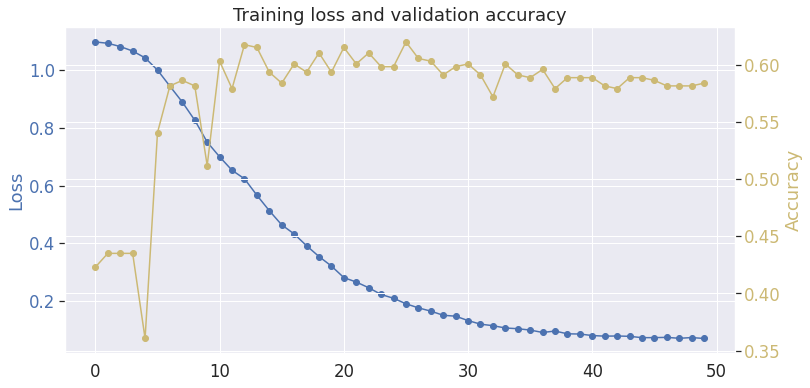

In [23]:
plot_loss_and_acc(model_loss_vals, model_eval_accs)

## Model Predictions

In [ ]:
import torch 
import torch.nn as nn
from transformers import AutoTokenizer
from gensim.models import Word2Vec
pretrained = "bert-base-cased"
bert_tokenizer = AutoTokenizer.from_pretrained(pretrained)


In [ ]:
def predict(inputs, inputs_w2v, tokenizer, model):
  with torch.no_grad():
    max_len = max([len(tokenizer(datapoint)['input_ids']) for datapoint in inputs])
    tokenized_inputs = tokenizer(
      inputs.tolist(),          # Input text
      add_special_tokens=True,  # add '[CLS]' and '[SEP]'
      padding='max_length',     # pad to a length specified by the max_length
      max_length=max_len,       # truncate all sentences longer than max_length
      return_tensors='pt',      # return everything we need as PyTorch tensors
    )
    output = model(input_ids = tokenized_inputs['input_ids'],
                   w2v_embeds = inputs_w2v)
    output = nn.functional.softmax(output[0], dim = 1).detach().numpy()
    output = output.argmax(axis = 1)
  return output

In [ ]:
# data
df = pd.DataFrame({
    'msgs' : ["gachiBASS Clap gachiBASS Clap gachiBASS Clap gachiBASS Clap", "i actually hate you FeelsBadMan", "OMEGALUL SO BAD", "test input test wow", "new wowowei"]
})

# load and train w2v then get embeds
#w2v_model = Word2Vec.load('w2v_labeled.model')
messages_w2v = [message.split(' ') for message in df.msgs] 
w2v_model.build_vocab(messages_w2v, update = True) # update w2v vocab
w2v_model.train(messages_w2v, total_examples = len(messages_w2v), epochs = w2v_model.epochs)
messages_w2v = torch.Tensor([w2v_model.wv[message].sum(axis = 0) for message in messages_w2v])

# prediction
model.to("cpu")
pred = predict(df.msgs, messages_w2v, bert_tokenizer, model)

In [ ]:
pred

array([2, 0, 0, 1, 2])

In [ ]:
# If predict script included
!python3 predict.py bert-base-cased .\\weights\\curr w2v_labeled.model "S OMEGALUL BAD"

predict.py:77: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  messages_w2v = torch.Tensor([w2v_model.wv[message].sum(axis = 0) for message in messages_w2v]) # get w2v embeds
Negative
